# A quick intro to `mandala`
`mandala` eliminates the developer effort typically required to persist, iterate
on, query, version and reproduce results of computational projects (like in
machine learning). 

It does so by automatically capturing code and data at calls
of decorated functions in a way that enables powerful queries and operations
over program traces.

In [ ]:
# Run this if in a Google Colab notebook
!pip install git+https://github.com/amakelov/mandala

# The `@op` decorator: automatic memoization and versioning
`@op` tracks the inputs, outputs, code and dependencies of calls to Python
functions. The same call is never executed twice:

In [1]:
from mandala._next.imports import *
import time

storage = Storage(deps_path='__main__') # stores all `@op` calls

@op
def inc(x):
    print("Hello from inc!")
    time.sleep(1) # simulate a long operation
    return x + 1

with storage: # all `@op` calls inside this block will be stored in `storage`
    start = time.time()
    a = inc(1)
    b = inc(1) # this will not be executed, but reused
    end = time.time()
    print(f'Took {round(end - start)} seconds')

Hello from inc!
Took 1 seconds


# `ComputationFrame`s: generalized dataframes for querying program traces
`@op`s are designed to be composed with one another like ordinary Python
functions. This automatically keeps track of the relationships between all saved
objects. 

The `ComputationFrame` class is used to explore and query these relationships:

Hello from inc!
Hello from add!
Hello from inc!
Hello from add!
Hello from inc!
Hello from inc!
Hello from add!


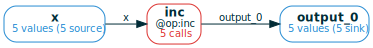

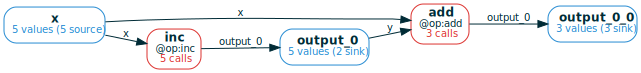

In [2]:
@op # define a new @op to compose with `inc`
def add(x, y):
    print("Hello from add!")
    return x + y

with storage:
    for i in range(5):
        j = inc(i)
        if i % 2 == 0:
            k = add(i, j)

cf = storage.cf(inc) # get the computation frame for all calls to `inc`
cf.draw(verbose=True, orientation='LR') # visualize the computation frame
cf.expand(inplace=True) # include all calls connected to the calls of `inc`
cf.draw(verbose=True, orientation='LR') # visualize the computation frame

Computation frames generalize dataframes:
- columns are replaced by a computational graph: functions whose input/output
edges connect to variables.
- rows are replaced by computation traces: variable values and function calls
that (possibly partially) follow this graph

**Any computation frame can be converted into a dataframe** for subsequent
analysis, where the columns are all nodes in the graph, and each row is a
computation trace, possibly padded with `NaN`s where no value/call is present:

In [3]:
cf.df()

Extracting tuples from the computation graph:
    output_0@output_0 = inc(x=x)
    output_0_0@output_0 = add(x=x, y=output_0)


,x,inc,output_0,add,output_0_0
0,1,"Call(inc, cid='9d3...', hid='66c...')",2,None,NaN
1,0,"Call(inc, cid='355...', hid='52f...')",1,"Call(add, cid='16b...', hid='38e...')",1.0
2,2,"Call(inc, cid='c38...', hid='ec7...')",3,"Call(add, cid='bbb...', hid='d3f...')",5.0
3,3,"Call(inc, cid='56b...', hid='f62...')",4,None,NaN
4,4,"Call(inc, cid='16b...', hid='f05...')",5,"Call(add, cid='2ee...', hid='5f0...')",9.0
